<a href="https://colab.research.google.com/github/shilpasy/Variant-Prioritization-miniproject-with-AlphaMissense-cBioPortal-and-ESM-models/blob/main/2_Fetch_cbioportal_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bravado

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.1 MB/s eta 0:00:00
  Created wheel for bravado: filename=bravado-12.0.1-py2.py3-none-any.whl size=37492 sha256=33bd8cee7cb4cd1c598f53b737a052543442f6a4f1d4b3e945484ca0ce5fb9a5
  Stored in directory: /root/.cache/pip/wheels/02/14/f5/8086cc8a76021701714fe4a4e55668f42ffe811465266e820d
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=41b6056703e06c3ecaa4be03ea92c78e6f6f7af5fa2583369c4c8b0714316218
  Stored in directory: /root/.cache/pip/wheels/b8/56/c6/3695a1daf18ee45607f1d352fca288d173bc3b1722228c6fb1
Successfully built bravado bravado-core


In [ ]:
from bravado.client import SwaggerClient
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                               config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})
print(cbioportal)

SwaggerClient(https://www.cbioportal.org/api)


In [ ]:
studies = cbioportal.Studies.getAllStudiesUsingGET().result()
cancer_types = cbioportal.Cancer_Types.getAllCancerTypesUsingGET().result()

print("In total there are {} studies in cBioPortal, spanning {} different types of cancer.".format(
    len(studies),
    len(cancer_types)
))

In total there are 497 studies in cBioPortal, spanning 891 different types of cancer.


In [ ]:
mutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='msk_impact_2017_mutations',
    sampleListId='msk_impact_2017_all',
    projection='DETAILED' ## note
).result()

In [ ]:
from collections import Counter
mutation_counts = Counter([m.gene.hugoGeneSymbol for m in mutations])
mutation_counts.most_common(5)

[('TP53', 4954),
 ('APC', 1674),
 ('KRAS', 1670),
 ('TERT', 1549),
 ('PIK3CA', 1517)]

In [ ]:
import pandas as pd
mdf = pd.DataFrame.from_dict([
    # combine two dictionaries:
    dict(
        {k:getattr(m,k) for k in dir(m)},
        **{k:getattr(m.gene,k) for k in dir(m.gene)})
    # create one item in the list for each mutation
    for m in mutations
])

In [ ]:
sample_count_per_gene = mdf.groupby('hugoGeneSymbol')['uniqueSampleKey'].nunique()
print("There are {} samples with a mutation in TP53".format(
    sample_count_per_gene['TP53']
))

There are 4538 samples with a mutation in TP53


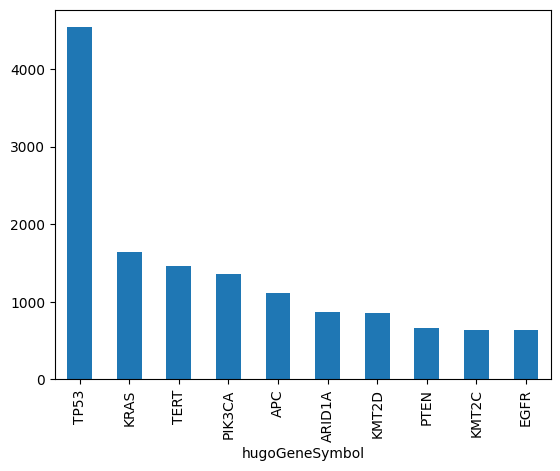

In [ ]:
sample_count_per_gene.sort_values(ascending=False).head(10).plot(kind='bar');

In [ ]:
mdf.columns

Index(['alleleSpecificCopyNumber', 'aminoAcidChange', 'center', 'chr',
       'driverFilter', 'driverFilterAnnotation', 'driverTiersFilter',
       'driverTiersFilterAnnotation', 'endPosition', 'entrezGeneId', 'gene',
       'keyword', 'molecularProfileId', 'mutationStatus', 'mutationType',
       'namespaceColumns', 'ncbiBuild', 'normalAltCount', 'normalRefCount',
       'patientId', 'proteinChange', 'proteinPosEnd', 'proteinPosStart',
       'referenceAllele', 'refseqMrnaId', 'sampleId', 'startPosition',
       'studyId', 'tumorAltCount', 'tumorRefCount', 'uniquePatientKey',
       'uniqueSampleKey', 'validationStatus', 'variantAllele', 'variantType',
       'geneticEntityId', 'hugoGeneSymbol', 'type'],
      dtype='object')

In [ ]:
mdf.variantType.value_counts()

,count
variantType,
SNP,65861
DEL,8193
INS,2907
DNP,1039
ONP,80
TNP,62


In [ ]:
mdf['mutationType'].value_counts()

,count
mutationType,
Missense_Mutation,55528
Nonsense_Mutation,7926
Frame_Shift_Del,6298
Splice_Site,2745
Frame_Shift_Ins,2486
5'Flank,1358
In_Frame_Del,1352
In_Frame_Ins,293
Translation_Start_Site,106


In [ ]:
tp53_missense = mdf[
    (mdf['hugoGeneSymbol'] == 'TP53') &
    (mdf['mutationType'].str.contains('Missense_Mutation', case=False, na=False)) &
    (mdf['proteinChange'].notna())]

In [ ]:
tp53_missense

,alleleSpecificCopyNumber,aminoAcidChange,center,chr,driverFilter,driverFilterAnnotation,driverTiersFilter,driverTiersFilterAnnotation,endPosition,entrezGeneId,...,tumorAltCount,tumorRefCount,uniquePatientKey,uniqueSampleKey,validationStatus,variantAllele,variantType,geneticEntityId,hugoGeneSymbol,type
650,None,None,NA,17,None,None,None,None,7578479,7157,...,212,26,UC0wMDAxOTg1Om1za19pbXBhY3RfMjAxNw,UC0wMDAxOTg1LVQwMS1JTTM6bXNrX2ltcGFjdF8yMDE3,NA,A,SNP,None,TP53,protein-coding
651,None,None,NA,17,None,None,None,None,7578479,7157,...,356,287,UC0wMDAyMDk3Om1za19pbXBhY3RfMjAxNw,UC0wMDAyMDk3LVQwMS1JTTM6bXNrX2ltcGFjdF8yMDE3,NA,A,SNP,None,TP53,protein-coding
652,None,None,NA,17,None,None,None,None,7578479,7157,...,33,554,UC0wMDAzMDE2Om1za19pbXBhY3RfMjAxNw,UC0wMDAzMDE2LVQwMS1JTTM6bXNrX2ltcGFjdF8yMDE3,NA,A,SNP,None,TP53,protein-coding
653,None,None,NA,17,None,None,None,None,7578479,7157,...,106,180,UC0wMDAzNTUxOm1za19pbXBhY3RfMjAxNw,UC0wMDAzNTUxLVQwMS1JTTU6bXNrX2ltcGFjdF8yMDE3,NA,A,SNP,None,TP53,protein-coding
654,None,None,NA,17,None,None,None,None,7578479,7157,...,83,171,UC0wMDAzODYwOm1za19pbXBhY3RfMjAxNw,UC0wMDAzODYwLVQwMS1JTTU6bXNrX2ltcGFjdF8yMDE3,NA,A,SNP,None,TP53,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77083,None,None,NA,17,None,None,None,None,7578499,7157,...,299,31,UC0wMDA5NDUwOm1za19pbXBhY3RfMjAxNw,UC0wMDA5NDUwLVQwMS1JTTU6bXNrX2ltcGFjdF8yMDE3,NA,CC,DNP,None,TP53,protein-coding
77239,None,None,NA,17,None,None,None,None,7579512,7157,...,209,683,UC0wMDEwMDU3Om1za19pbXBhY3RfMjAxNw,UC0wMDEwMDU3LVQwMS1JTTU6bXNrX2ltcGFjdF8yMDE3,NA,G,SNP,None,TP53,protein-coding
77929,None,None,NA,17,None,None,None,None,7578207,7157,...,658,931,UC0wMDA4Mjk5Om1za19pbXBhY3RfMjAxNw,UC0wMDA4Mjk5LVQwMi1JTTU6bXNrX2ltcGFjdF8yMDE3,NA,C,SNP,None,TP53,protein-coding
77930,None,None,NA,17,None,None,None,None,7578207,7157,...,430,738,UC0wMDA4Mjk5Om1za19pbXBhY3RfMjAxNw,UC0wMDA4Mjk5LVQwMS1JTTU6bXNrX2ltcGFjdF8yMDE3,NA,C,SNP,None,TP53,protein-coding


In [ ]:
tp53_missense['proteinChange']

,proteinChange
650,P151S
651,P151S
652,P151S
653,P151S
654,P151S
...,...
77083,Q144P
77239,G59R
77929,H214Q
77930,H214Q


In [ ]:
from google.colab import drive
import pandas as pd
import gzip
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tp53_missense['Variant'] = tp53_missense['proteinChange'].str.replace('p.', '', regex=False) # we may not have to do this if there aren't such instances in data imported from cbioportal
# load AlphaMissense AM data
am_df = pd.read_csv("/content/drive/MyDrive/AlphaMissense_ex/TP53_AlphaMissense_Annotations.csv") #this file was generated in Tp53 Alpha Missense Colab.ipynb notebook - in brief these are all possible missense mutations in p53 with their AlphaMissense annotations

/tmp/ipython-input-442704789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp53_missense['Variant'] = tp53_missense['proteinChange'].str.replace('p.', '', regex=False)


In [ ]:
am_df

,WT_AA,Position,Mut_AA,Variant,UniProt_ID,AlphaMissense_Pathogenicity,AlphaMissense_Class
0,M,1,A,M1A,P04637,0.4065,ambiguous
1,M,1,C,M1C,P04637,0.5110,ambiguous
2,M,1,D,M1D,P04637,0.8213,pathogenic
3,M,1,E,M1E,P04637,0.5521,ambiguous
4,M,1,F,M1F,P04637,0.3445,ambiguous
...,...,...,...,...,...,...,...
10160,P,535,S,P535S,NaN,NaN,NaN
10161,P,535,T,P535T,NaN,NaN,NaN
10162,P,535,V,P535V,NaN,NaN,NaN
10163,P,535,W,P535W,NaN,NaN,NaN


In [ ]:
# merge on Variant
merged = tp53_missense.merge(am_df, on='Variant', how='left')

In [ ]:
merged.columns

Index(['alleleSpecificCopyNumber', 'aminoAcidChange', 'center', 'chr',
       'driverFilter', 'driverFilterAnnotation', 'driverTiersFilter',
       'driverTiersFilterAnnotation', 'endPosition', 'entrezGeneId', 'gene',
       'keyword', 'molecularProfileId', 'mutationStatus', 'mutationType',
       'namespaceColumns', 'ncbiBuild', 'normalAltCount', 'normalRefCount',
       'patientId', 'proteinChange', 'proteinPosEnd', 'proteinPosStart',
       'referenceAllele', 'refseqMrnaId', 'sampleId', 'startPosition',
       'studyId', 'tumorAltCount', 'tumorRefCount', 'uniquePatientKey',
       'uniqueSampleKey', 'validationStatus', 'variantAllele', 'variantType',
       'geneticEntityId', 'hugoGeneSymbol', 'type', 'Variant', 'WT_AA',
       'Position', 'Mut_AA', 'UniProt_ID', 'AlphaMissense_Pathogenicity',
       'AlphaMissense_Class'],
      dtype='object')

In [ ]:
output_path_mergedwith_cbioportal = "/content/drive/MyDrive/AlphaMissense_ex/TP53_cbioportal_mutations_annotated_with_AlphaMissense.csv"
merged.to_csv(output_path_mergedwith_cbioportal, index=False)

print(f"✅ Merged data saved to: {output_path_mergedwith_cbioportal}")

✅ Merged data saved to: /content/drive/MyDrive/AlphaMissense_ex/TP53_cbioportal_mutations_annotated_with_AlphaMissense.csv


TP53 Mutation Class Distribution:
 AlphaMissense_Class
pathogenic    403
benign         39
ambiguous       1
Name: count, dtype: int64


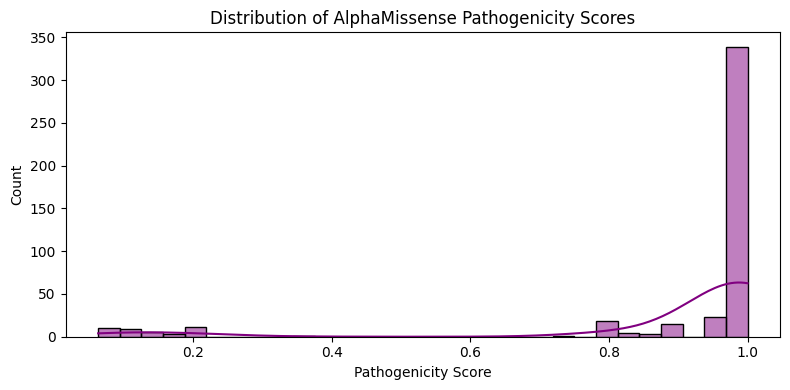


Top Recurrent proteinChange Variants:
 proteinChange
R175H    209
R248Q    152
R273H    137
R273C    125
R248W    113
R282W     97
G245S     75
Y220C     49
E285K     40
V157F     31
Name: count, dtype: int64


In [ ]:
##### lets explore this merged file #######
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/AlphaMissense_ex/TP53_cbioportal_mutations_annotated_with_AlphaMissense.csv")

# 1. count(TP53 mutations by AlphaMissense_Class)
class_counts = df['AlphaMissense_Class'].value_counts()
print("TP53 Mutation Class Distribution:\n", class_counts)

# 2. histogram AlphaMissense_Pathogenicity scores
plt.figure(figsize=(8, 4))
sns.histplot(df['AlphaMissense_Pathogenicity'], bins=30, kde=True, color="purple")
plt.title("Distribution of AlphaMissense Pathogenicity Scores")
plt.xlabel("Pathogenicity Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. top recurrent proteinChange values
top_mutations = df['proteinChange'].value_counts().head(10)
print("\nTop Recurrent proteinChange Variants:\n", top_mutations)

# AlphaMissense pathogenicity vs protein position

[Info] Points available to plot: 443


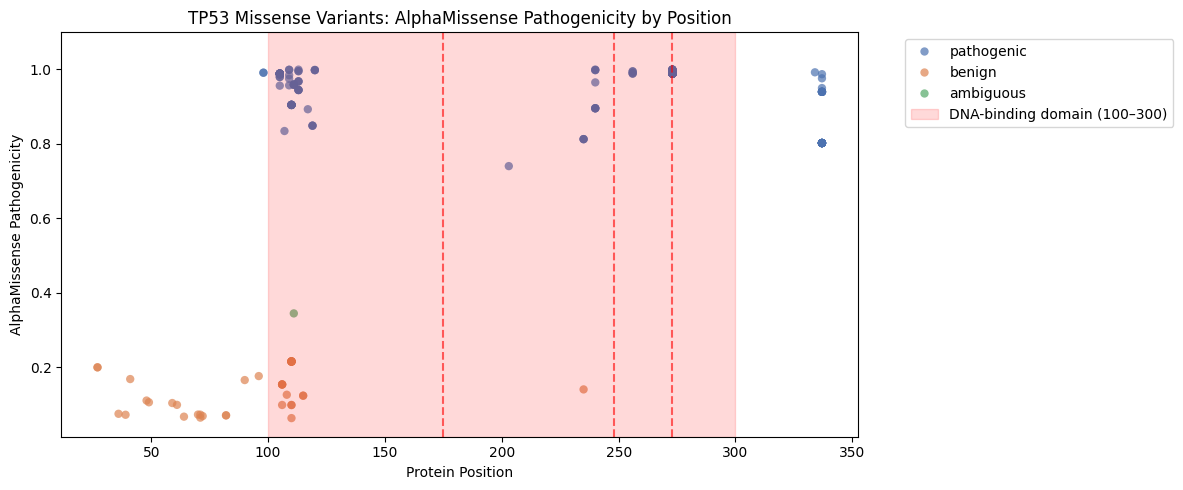

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df  # noqa: F821 (use existing df if present)
except NameError:
    df = pd.read_csv("TP53_Mutations_Annotated_with_AlphaMissense.csv") #TP53_cbioportal_mutations_annotated_with_AlphaMissense.csv

plot_df = df.copy()

# coerce to numeric
plot_df["Position_num"] = pd.to_numeric(plot_df["Position"], errors="coerce")
plot_df["AM_score"] = pd.to_numeric(plot_df["AlphaMissense_Pathogenicity"], errors="coerce")

if "AlphaMissense_Class" in plot_df.columns:
    # keep rows where we actually have a class (drop completely empty AM rows)
    pass
plot_df = plot_df.dropna(subset=["Position_num", "AM_score"])

if plot_df.empty and "AlphaMissense_Class" in df.columns:
    plot_df = df[df["AlphaMissense_Class"].isin(["pathogenic","ambiguous"])].copy()
    plot_df["Position_num"] = pd.to_numeric(plot_df["Position"], errors="coerce")
    plot_df["AM_score"] = pd.to_numeric(plot_df["AlphaMissense_Pathogenicity"], errors="coerce")
    plot_df = plot_df.dropna(subset=["Position_num", "AM_score"])

print(f"[Info] Points available to plot: {len(plot_df)}")

if plot_df.empty:
    plt.figure(figsize=(8,3))
    plt.text(0.5, 0.5, "No valid (Position, AlphaMissense) pairs to plot",
             ha="center", va="center", fontsize=12)
    plt.axis("off")
    plt.show()
else:
    # normalise proteinChange for hotspot label matching (if present)
    if "proteinChange" in df.columns:
        plot_df["proteinChange_norm"] = (
            plot_df["proteinChange"].astype(str)
            .str.replace("p.", "", regex=False)
            .str.upper()
        )
    else:
        plot_df["proteinChange_norm"] = ""

    plt.figure(figsize=(12, 5))
    hue_col = "AlphaMissense_Class" if "AlphaMissense_Class" in plot_df.columns else None

    sns.scatterplot(
        data=plot_df,
        x="Position_num",
        y="AM_score",
        hue=hue_col,
        palette="deep" if hue_col else None,
        alpha=0.7,
        edgecolor="none"
    )

    # ******* shade DNA-binding domain #
    plt.axvspan(100, 300, color="red", alpha=0.15, label="DNA-binding domain (100–300)")

    # draw popular hotspot codons
    hotspot_positions = {175: "R175", 248: "R248", 273: "R273"}
    for pos, tag in hotspot_positions.items():
        plt.axvline(pos, color="red", linestyle="--", alpha=0.6)
        # y-axis transform to place label at top
        ax = plt.gca()

    hotspot_variants = ["R175H", "R248Q", "R273H", "R273C"]
    for hs in hotspot_variants:
        mask = plot_df["proteinChange_norm"].eq(hs)
        if mask.any():
            pos_vals = plot_df.loc[mask, "Position_num"].dropna()
            y_vals   = plot_df.loc[mask, "AM_score"].dropna()
            if not pos_vals.empty and not y_vals.empty:
                pos = float(pos_vals.iloc[0])
                y   = float(y_vals.iloc[0])

    y_min = max(0.0, plot_df["AM_score"].min() - 0.05)
    y_max = min(1.1, plot_df["AM_score"].max() + 0.1)
    plt.ylim(y_min, y_max)

    plt.title("TP53 Missense Variants: AlphaMissense Pathogenicity by Position")
    plt.xlabel("Protein Position")
    plt.ylabel("AlphaMissense Pathogenicity")
    if hue_col:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [ ]:
print("Position range:", plot_df["Position_num"].min(), "to", plot_df["Position_num"].max())
print("AlphaMissense_Pathogenicity range:", plot_df["AM_score"].min(), "to", plot_df["AM_score"].max())
print(plot_df[["Position_num","AM_score","AlphaMissense_Class","proteinChange_norm"]].head(10))

Position range: 27.0 to 337.0
AlphaMissense_Pathogenicity range: 0.0631 to 0.9995
    Position_num  AM_score AlphaMissense_Class proteinChange_norm
19         113.0    0.9952          pathogenic              F113S
20         113.0    0.9952          pathogenic              F113S
34         273.0    0.9889          pathogenic              R273H
35         273.0    0.9889          pathogenic              R273H
36         273.0    0.9889          pathogenic              R273H
37         273.0    0.9889          pathogenic              R273H
38         273.0    0.9889          pathogenic              R273H
39         273.0    0.9889          pathogenic              R273H
40         273.0    0.9889          pathogenic              R273H
41         273.0    0.9889          pathogenic              R273H


In [ ]:
# save out just the pathogenic TP53 mutations if needed
pathogenic_df = df[df['AlphaMissense_Class'] == 'pathogenic']
output_path = "TP53_AlphaMissense_Pathogenic.csv"
pathogenic_df.to_csv(output_path, index=False)
print(f" saved {len(pathogenic_df)} pathogenic mutations to '{output_path}'")

 saved 403 pathogenic mutations to 'TP53_AlphaMissense_Pathogenic.csv'
